# Infinite Message Model: Solution

James Yu, 14 June 2022

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy.optimize

There are two equations required to formulate a solution to the infinite message model. The first is the expression for the shadow price $\mu$, which is the budget constraint with $\tilde{\mathbf{y}}_0$ substituted for $\tilde{\mathbf{x}}_0$ via the FOC for $\tilde{\mathbf{y}}_0$ using the solution guess $\tilde{\mathbf{y}}_t = D_k^t \tilde{\mathbf{y}}_0$:

$$\tilde{\mathbf{x}}_0^\prime (\mu (I + \mu I + \mu \delta D^2 - \mu \delta D D_k)^{-1} - I)^2 \tilde{\mathbf{x}}_0 + \delta \tilde{\mathbf{x}}_0^\prime \mu^2 (I + \mu I + \mu \delta D^2  - \mu \delta D D_k)^{-2} (D_k - D)^2 (I - \delta D_k^2)^{-1} \tilde{\mathbf{x}}_0 = C$$

The second is the solution to the second-order difference equation. The solutions $r_k$ are given by:

$$r_k = \frac{\lambda_k^2 + \mu + \mu \delta \lambda_k^2 \pm \sqrt{(\lambda_k^2 + \mu + \mu \delta \lambda_k^2)^2 - 4 \delta \mu^2 \lambda_k^2}}{2\delta\mu \lambda_k}$$

Note that $D_k$ is the diagonal matrix of each $r_k$ so both equations are dependent on $r_k$ and $\mu$. It would be extremely difficult to solve for $\mu$ analytically due to this fact on top of the fact that the budget constraint is already an implicit definition of $\mu$. We can instead use a numerical solution by searching for the $\mu$ that satisfies the equation.

In [2]:
def r_k(lambda_k, mu, delta):
    q_B = (lambda_k ** 2) + mu + (mu * delta * (lambda_k ** 2))
    q_A = delta * mu * lambda_k
    q_C = mu * lambda_k
    if True:#lambda_k > 0:
        return (q_B - math.sqrt((q_B ** 2) - (4 * q_A * q_C))) / (2 * q_A) # negative sign
    elif lambda_k < 0:
        return (q_B + math.sqrt((q_B ** 2) - (4 * q_A * q_C))) / (2 * q_A) # positive sign
    else:
        raise Exception("unhandled lambda_k = 0 case found")

In [3]:
r_k(1, 1, 0.9)

0.39268265558548265

In [4]:
r_k(-0.5, 1, 0.9)

-0.38396033354705367

Some quick checks:

In [5]:
def r_k_always_negative(lambda_k, mu, delta):
    q_B = (lambda_k ** 2) + mu + (mu * delta * (lambda_k ** 2))
    q_A = delta * mu * lambda_k
    q_C = mu * lambda_k
    return (q_B - math.sqrt((q_B ** 2) - (4 * q_A * q_C))) / (2 * q_A) # negative sign

print(r_k_always_negative(1, 1, 0.9))
print(r_k_always_negative(-0.5, 1, 0.9))

0.39268265558548265
-0.38396033354705367


In [6]:
print(r_k_always_negative(1, 900, 0.1))
print(r_k_always_negative(-0.01, 1, 0.1))

0.9987671230563504
-0.009999000090021859


In [7]:
def r_k_always_positive(lambda_k, mu, delta):
    q_B = (lambda_k ** 2) + mu + (mu * delta * (lambda_k ** 2))
    q_A = delta * mu * lambda_k
    q_C = mu * lambda_k
    return (q_B + math.sqrt((q_B ** 2) - (4 * q_A * q_C))) / (2 * q_A) # negative sign

print(r_k_always_positive(1, 1, 0.9))
print(r_k_always_positive(-0.5, 1, 0.9))

2.8295395666367393
-2.893817444230724


In [8]:
def y0_matrix(mu, delta, D, D_k, n):
    I = np.identity(n)
    return I + (mu * I) + (mu * delta * (D @ D)) - (mu * delta * (D @ D_k))

In [9]:
def budget_constraint(C, tilde_x_0, mu, D, D_k, delta, n):
    I = np.identity(n)
    y0_mat = y0_matrix(mu, delta, D, D_k, n)
    t_0_term = tilde_x_0.T @ np.linalg.matrix_power(((mu * np.linalg.inv(y0_mat)) - I), 2) @ tilde_x_0
    t_sum_term = delta * (mu ** 2) * tilde_x_0.T @ np.linalg.matrix_power(np.linalg.inv(y0_mat), 2) @ (D_k - D) @ (D_k - D) @ np.linalg.inv(I - (delta * (D_k @ D_k))) @ tilde_x_0
    return C - t_0_term - t_sum_term # given the correct mu, this should be zero

Next, we need to formulate a specific network to solve. For example:

In [10]:
x_0 = np.array([[4.0, 10.0, -3.0]], ndmin = 2).T
x_0

array([[ 4.],
       [10.],
       [-3.]])

$A$ must be symmetric in order to perform the eigendecomposition:

In [11]:
A = np.array([
    [0.6, 0.2, 0.2],
    [0.2, 0.3, 0.5],
    [0.2, 0.5, 0.3]
])
A

array([[0.6, 0.2, 0.2],
       [0.2, 0.3, 0.5],
       [0.2, 0.5, 0.3]])

In [12]:
eigvals, U = np.linalg.eig(A)
D = np.diag(eigvals)
np.allclose(U @ D @ U.T, A)

True

This means we have the proper decomposition, since $U D U^\prime$ returns $A$:

In [13]:
U @ D @ U.T

array([[0.6, 0.2, 0.2],
       [0.2, 0.3, 0.5],
       [0.2, 0.5, 0.3]])

We also need a function to compose $D_k$ from each $r_k$:

In [14]:
def D_k_(mu, delta, eigenvalues):
    return np.diag([r_k(lambda_k, mu, delta) for lambda_k in eigenvalues])

In [15]:
D_k_(1, 0.9, eigvals)

array([[ 0.33835439,  0.        ,  0.        ],
       [ 0.        ,  0.39268266,  0.        ],
       [ 0.        ,  0.        , -0.19204322]])

This allows us to create the following:

In [16]:
def objective_function(mu_vec, A_, C, x_0_, delta, use_vec = False, suppress_print = False, permit_negative = False):
    if not suppress_print:
        print("testing", mu_vec)
    if use_vec:
        mu = mu_vec[0]
    else:
        mu = mu_vec
    if mu <= 0 and not permit_negative:
        # do not allow negative
        return -1 * np.inf
    n = np.size(x_0_)
    eigvals, U = np.linalg.eig(A_)
    D = np.diag(eigvals)
    tilde_x_0 = U.T @ x_0_
    D_k = D_k_(mu, delta, eigvals)
    return budget_constraint(C, tilde_x_0, mu, D, D_k, delta, n).item()

This is an expression for the budget constraint solely in terms of $x_0$, $A$, $C$, $\delta$ and a candidate $\mu$.

In [17]:
C = 10
delta = 0.9

In [18]:
objective_function(1, A, C, x_0, delta)

testing 1


-28.472764770520723

So now, given the fixed network parameters, we can find the $\mu$ which sets this function to zero. Here are two example solvers from the SciPy library that can do this:

In [19]:
res = scipy.optimize.fsolve(lambda mu: objective_function(mu, A, C, x_0, delta, use_vec = True), 1)

testing [1]
testing [1.]
testing [1.]
testing [1.00000001]
testing [1.98765005]
testing [2.70094715]
testing [3.6378817]
testing [4.34874493]
testing [4.76081028]
testing [4.88356342]
testing [4.89818966]
testing [4.89859912]
testing [4.89860035]
testing [4.89860035]


In [20]:
res2 = scipy.optimize.brentq(lambda mu: objective_function(mu, A, C, x_0, delta), 0.00000001, 5000)

testing 1e-08
testing 5000.0
testing 4600.055276186278
testing 2300.027638098139
testing 1150.0138190540695
testing 575.0069095320347
testing 287.50345477101735
testing 143.75172739050868
testing 71.87586370025434
testing 35.93793185512717
testing 17.968965932563584
testing 8.984482971281793
testing 4.492241490640897
testing 5.223525793348178
testing 4.924766615975127
testing 4.8984666323946895
testing 4.898601040080625
testing 4.89860034694159
testing 4.898600346923227
testing 4.898600346924229


In [21]:
res.item()

4.8986003469232235

In [22]:
res2

4.898600346923227

With respect to rounding error, they yield the same result. Thus, this is a $\mu$ which satisfies the equation. We can validate:

In [23]:
objective_function(res.item(), A, C, x_0, delta)

testing 4.8986003469232235


-7.105427357601002e-15

With respect to rounding error, this is zero. So it satisfies the budget constraint. We can now use it to retrive the roots:

In [24]:
[r_k(lambda_k, res.item(), delta) for lambda_k in eigvals]

[0.38538471062286367, 0.6636233029035763, -0.1983206442271697]

One of the next questions is whether $\mu$ changes with $C$ the way we expect it to. We can check:

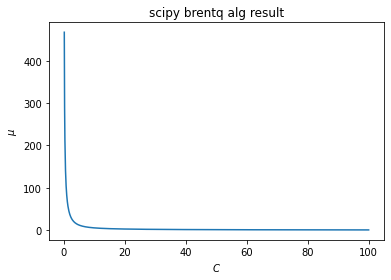

In [25]:
results = []
for C_ in np.linspace(0.1, 100, 1000):
    results.append(scipy.optimize.brentq(lambda mu: objective_function(mu, A, C_, x_0, delta, suppress_print = True), 0.00000001, 5000))
    
plt.plot(np.linspace(0.1, 100, 1000), results)
plt.xlabel("$C$")
plt.ylabel("$\mu$")
plt.title("scipy brentq alg result")
plt.show()

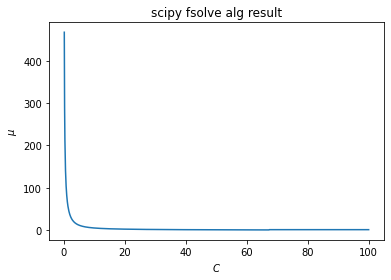

In [26]:
results = []
for C_ in np.linspace(0.1, 100, 1000):
    results.append(scipy.optimize.fsolve(lambda mu: objective_function(mu, A, C_, x_0, delta, use_vec = True, suppress_print = True), 1))
    
plt.plot(np.linspace(0.1, 100, 1000), results)
plt.xlabel("$C$")
plt.ylabel("$\mu$")
plt.title("scipy fsolve alg result")
plt.show()

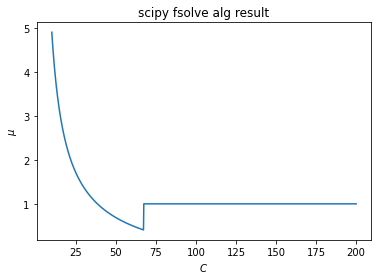

In [27]:
results = []
for C_ in np.linspace(10, 200, 1000):
    results.append(scipy.optimize.fsolve(lambda mu: objective_function(mu, A, C_, x_0, delta, use_vec = True, suppress_print = True), 1))
    
plt.plot(np.linspace(10, 200, 1000), results)
plt.xlabel("$C$")
plt.ylabel("$\mu$")
plt.title("scipy fsolve alg result")
plt.show()

Fsolve is bad here because as it gets close to zero, it appears to give up (the horizontal line is the initial guess that I put into the algorithm). If we change it, we get:

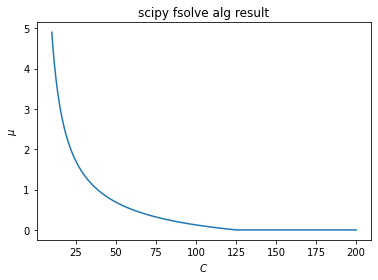

In [28]:
results = []
for C_ in np.linspace(10, 200, 1000):
    results.append(scipy.optimize.fsolve(lambda mu: objective_function(mu, A, C_, x_0, delta, use_vec = True, suppress_print = True), 0.00001))
    
plt.plot(np.linspace(10, 200, 1000), results)
plt.xlabel("$C$")
plt.ylabel("$\mu$")
plt.title("scipy fsolve alg result")
plt.show()

Now the horizontal line is closer to zero. So we can try the other algorithm:

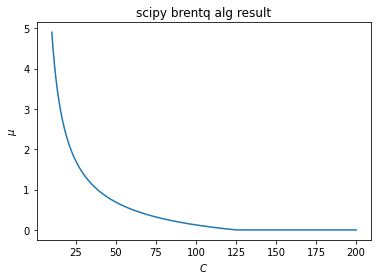

In [29]:
results = []
for C_ in np.linspace(10, 200, 1000):
    results.append(scipy.optimize.brentq(lambda mu: objective_function(mu, A, C_, x_0, delta, suppress_print = True), 0, 5000))
    
plt.plot(np.linspace(10, 200, 1000), results)
plt.xlabel("$C$")
plt.ylabel("$\mu$")
plt.title("scipy brentq alg result")
plt.show()

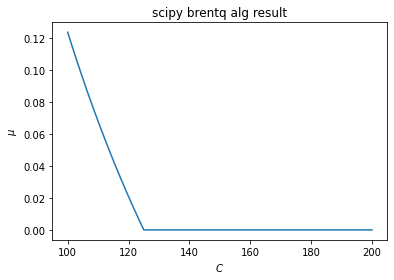

In [30]:
results = []
for C_ in np.linspace(100, 200, 1000):
    results.append(scipy.optimize.brentq(lambda mu: objective_function(mu, A, C_, x_0, delta, suppress_print = True), 0, 5000))
    
plt.plot(np.linspace(100, 200, 1000), results)
plt.xlabel("$C$")
plt.ylabel("$\mu$")
plt.title("scipy brentq alg result")
plt.show()

This appears to be the $C$ at which the constraint no longer binds, given that the trajectory is not tangent to zero but rather stops at it.